# Programming Language Prediction Project

## Goal:
- Discover features of README.md files that indicate the repository programming language
- Use features to develop a machine learning model to predict the repository's main programming language

# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import acquire as a
import wrangle as w
import explore as e
# import model as m
# import evaluate as ev

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import unicodedata
import nltk
from wordcloud import WordCloud
import os
import json

# import for exploring
from sklearn.model_selection import train_test_split
import scipy.stats as stats

# import for model 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


# Acquire
- Aquire a corpus of GitHub repository README files via GitHub API. 
- Our data comes from the top 100 most-starred repositories on GitHub current as of 27 Jun 2023.
- It contained 119 rows and 3 columns before cleaning
- Each row represents a repository.
- Each column represents the features of repository: repo name, language, README text

# Prepare
- Clean text by making all text lowercase
- Removed special characters
- Tokenizing the words into discrete units
- lemmatizing them to get word roots
- Nulls: dropped 9 rows that had null for language
- Checked that column data types were appropriate
- We changed language to 'other' for languages other than the top 6 languages
    - The top 6 languages in this dataset are Objective-C, Java, JavaScript, Python, Ruby, and Swift
    - There were 19 different languages in our dataset, 6 of which occurred only once, and 4 only twice
- Split data into train, validate, and test (60/20/20), stratifying on language.

# Data Dictionary

| Feature Name | Data Type | Description | Example |
| ----- | ----- | ----- | ----- |
| repo | object | Name of Repository | 'spolu/breach_core' |
| language | object | Predominant coding language of Repository | 'JavaScript' |
| readme_contents | object | Contents of Repository's README file | '### Breach: A Browser for the HTML5 Era...' |
| lemmatized | object | Cleaned version of contents of Repository's README file | 'breach browser html5 era modular everything...' |
| readme_length | integer | number of characters in the README file | 1069 |

In [2]:
## acquire and prepare data for exploration
df = a.get_data_json()
df = w.clean_df(df)

In [3]:
## split data into train, validate, and test
train, validate, test = w.split_data(df)

# A brief look at the data

In [4]:
train.head()

,repo,language,readme_contents,lemmatized,readme_length
70,inkling/Subliminal,Objective-C,"<p align=""center"" >\n <img src=""http://inklin...",p aligncenter img srchttpinklinggithubiosublim...,11215
59,microsoftarchive/android-sliding-layer-lib,Java,6Wunderkinder SlidingLayer for Android\n======...,6wunderkinder slidinglayer android repository ...,4266
92,jamesob/tinychain,Python,"# ⛼ tinychain\n\n*Putting the rough in ""[roug...",tinychain putting rough rough consensushttpsto...,8333
104,Cleveroad/CRNetworkButton,Swift,# CRNetworkButton [![Awesome](https://cdn.rawg...,crnetworkbutton awesomehttpscdnrawgitcomsindre...,5268
97,zhangxinxu/mobilebone,JavaScript,"mobilebone.js\n=============\n\n<img src=""http...",mobilebonejs img srchttpswwwzhangxinxucomgithu...,5908


## A summary of the data

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 70 to 75
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             66 non-null     object
 1   language         66 non-null     object
 2   readme_contents  66 non-null     object
 3   lemmatized       66 non-null     object
 4   readme_length    66 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 3.1+ KB


In [6]:
train.describe()

,readme_length
count,66.000000
mean,9124.742424
std,25242.379029
min,251.000000
25%,2835.000000
50%,4877.500000
75%,6918.250000
max,206311.000000


# Explore

## Question 1 What are the most common words in READMEs?

In [7]:
# split the words individually up and lemmatize them                                                                                                                                                                                                                                                                                                            
git_lem_words =" ".join(train.lemmatized).split()

lem_freq = pd.Series(git_lem_words).value_counts()

# create df of freq words
word_counts = pd.concat([lem_freq], axis=1).fillna(0).astype(int)

# rename the col names
word_counts.columns = ["lemmatize"]

# create df of most common words
word_counts.head(10)

,lemmatize
rust,451
build,277
use,215
library,204
file,147
user,143
using,138
install,138
code,137
example,131


* The top five most common words are: rust, build, use, library, and file

## Question 2:  Is readme_length associated with language?

## Visualize

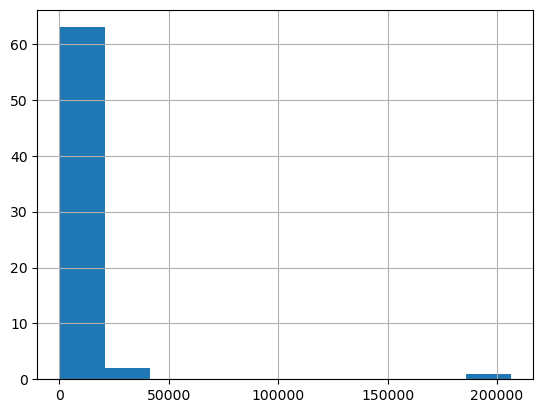

In [8]:
# first plot distribution of readme_length
train.readme_length.hist()
plt.show()

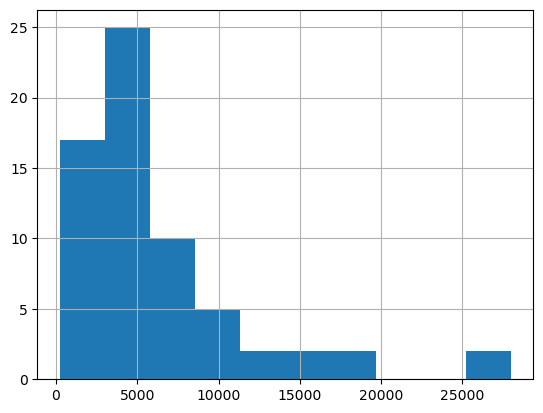

In [9]:
# One entry has a readme_length far above normal
# In order to zoom in on the distribution of the majority, let's view distribution without that outlier
train[train.readme_length<50000].readme_length.hist()
plt.show()

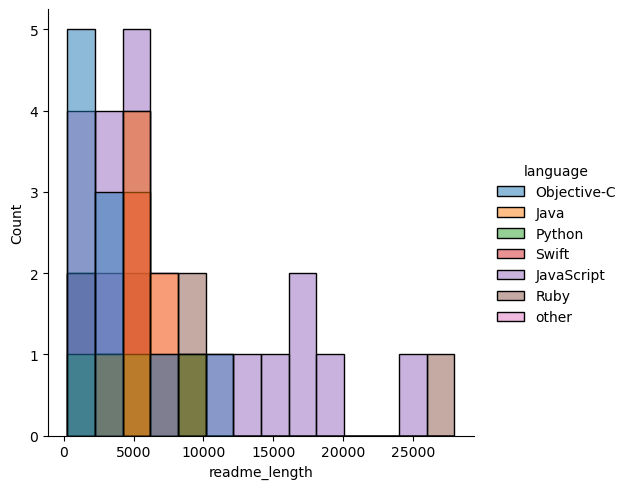

In [10]:
# make a histplot hued by language to visualize if readme_length is related to language at all
sns.displot(data=train[train.readme_length<50000],x='readme_length', hue='language', kind='hist') 
plt.show()

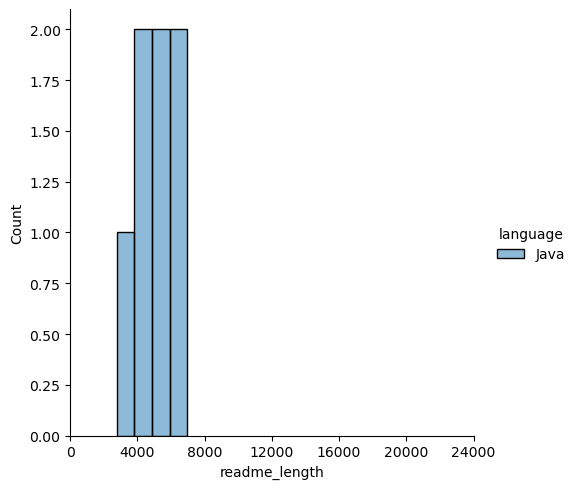

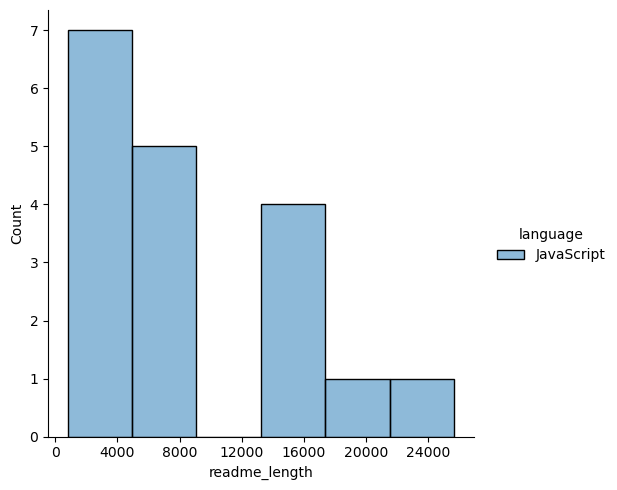

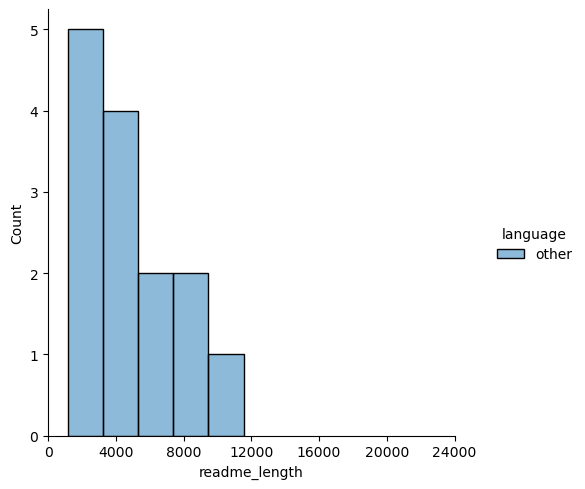

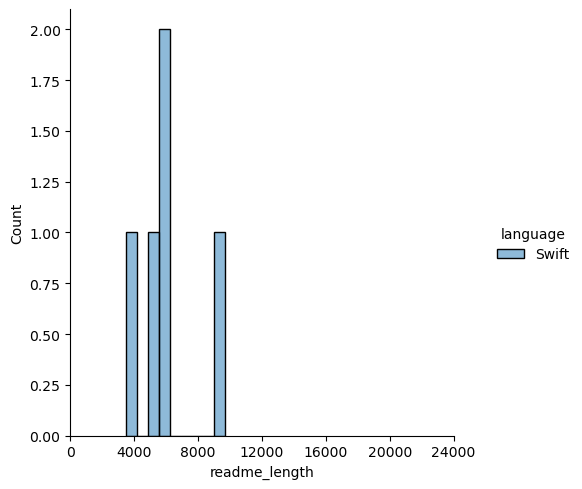

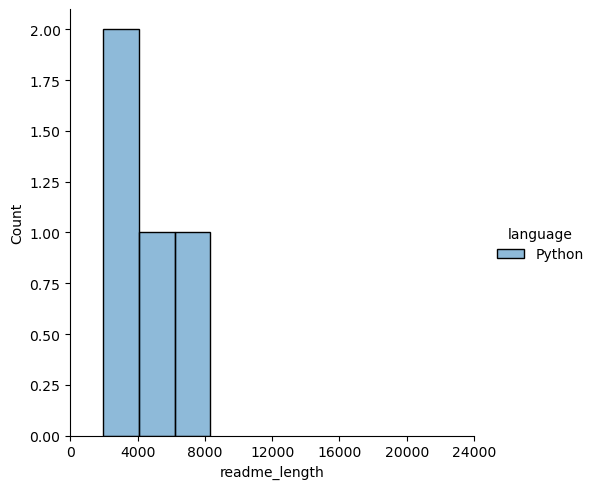

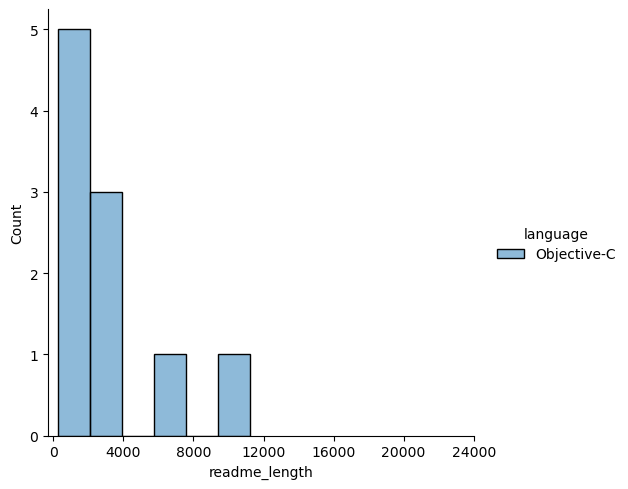

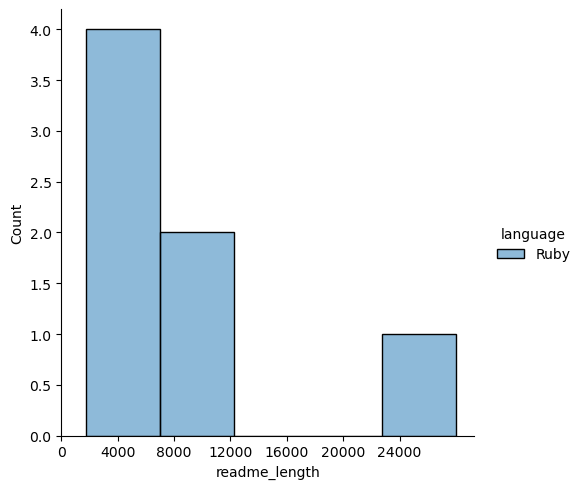

In [11]:
# the plot with everything on top of each other wasn't very useful, so
# plot histplots of readme_length separately for each language, still leaving off the outlier for now
for l in df.language.unique():
    sns.displot(data=train[(train.readme_length<50000) & (train.language == l)],x='readme_length', hue='language', kind='hist') 
    plt.xticks(ticks=range(0,28000, 4000))
    plt.show()

### Analyze readme_length vs language with statistics
- $H_0$ There is NO relationship between readme_length and language
- $H_a$ There IS a relationship
- $\alpha$ = .05
continuous vs categorical, not normally distributed, comparing > 2 subgroup means to each other
=> kruskal wallis test

In [12]:
# kruskal wallis requires array-like inputs: sending in all readme_lengths for each language
stats.kruskal(train[train.language=='Java'].readme_length
            , train[train.language=='Python'].readme_length
            , train[train.language=='Swift'].readme_length
            , train[train.language=='JavaScript'].readme_length
            , train[train.language=='Ruby'].readme_length
            , train[train.language=='Objective-C'].readme_length
            , train[train.language=='other'].readme_length)

KruskalResult(statistic=9.8560431371574, pvalue=0.13084673173089884)

### Summarize readme_length vs language

- p is > .05, so we CANNOT reject the null hypothesis 
- In summary, there is no association between readme_length and language

## Question 3 Are there any words that uniquely identify a programming language?

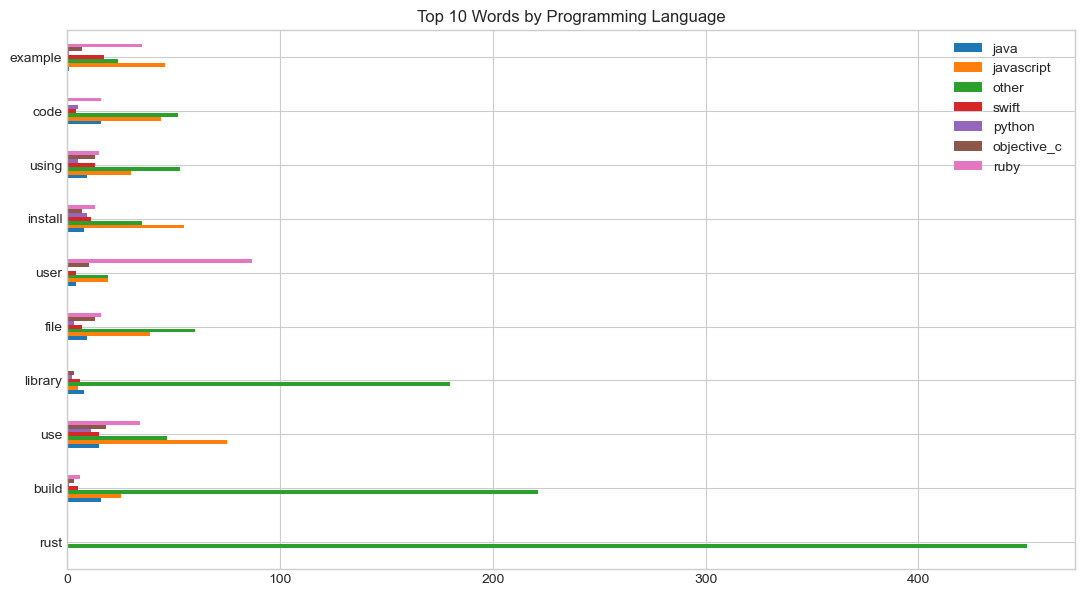

In [13]:
# top 10 word visualizes
e.get_word_viz(train)

### Summarize
* `Rust` was the most common for the other languages,
* `Use` was more profound in the JavaScript Langauge
* `User` was used more in Ruby 

## Question 4 Are there bigrams or n-grams that can uniquely identify a programming language?

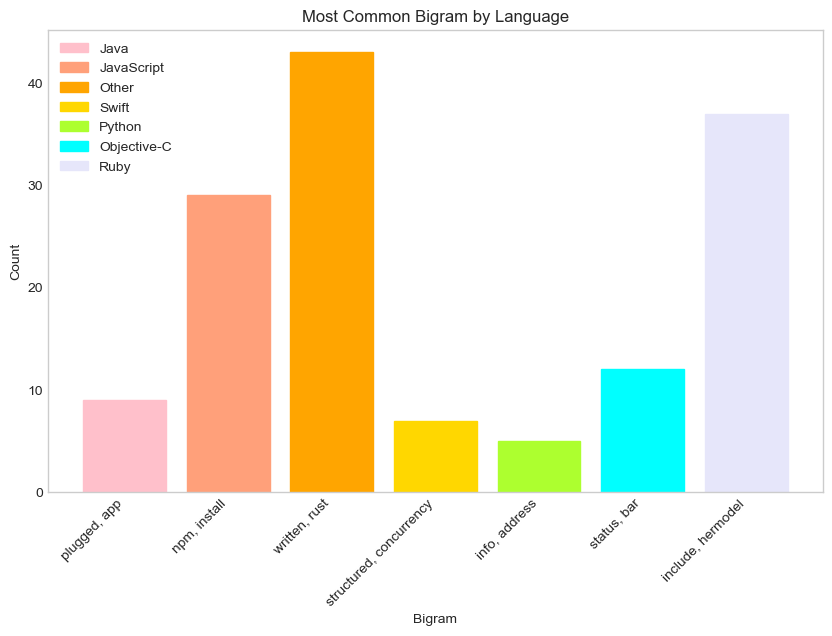

In [14]:
# visual of most common bigram by language
e.plot_bigrams_graph()

### Summarize
* All of the languages had a unique bigrams except for JavaScript and Objective-C. 
* `npm install` npm is a package manager for the JavaScript programming language

## Exploration Summary
* The top five most common words are: rust, build, use, library, and file
* Length of the readme was NOT associated with the programming language
* Features that have a relationship with target are:
    * The words themselves. Many words show up in a particular programming language README much more often than in the other language README's.
        * Example: The language category other is the only category that had the word 'rust'
    * Bigrams. Several bigrams were unique to a particular language
        * Example: (plugged, app) was only found in Java

### Features we are moving to modeling with: words, bigrams

### Features we are not moving to modeling with: readme_length

# Modeling
* Evaluation Metrics: We will use accuracy as our evaluation metrics
    * Baseline is 0.27 (guessing 'JavaScript' for every entry would have been correct 27% of the time)
* We will evaluate 3 different model types and various hyperparameter configurations
    * The three model types are DecisionTree, Random Forest, KNN
    * We will evaluate on words alone, bigrams alone, and words and bigrams*
* Models will be evaluated on train and validate data
* The model that performs the best will then be evaluated on test

\*words alone produced the best models, and that is all that is shown below

In [15]:
## prep data for modeling
# get X y splits for modeling
train, validate, test, x_train, y_train, x_validate, y_validate, x_test, y_test = e.split_data_xy(train, validate, test)

# create baseline 
baseline_accuracy = (train.language == "JavaScript").mean()
round(baseline_accuracy, 2)

train -> (66, 5)
validate -> (22, 5)
test -> (22, 5)


0.27

### Note: CountVectorizer is used below. Additionally, TfidfVectorizer was tried, but it did not yield better results.

In [16]:
# create bag of words for train, validate, test (fitting on train only)
cv = CountVectorizer()
x_bow = cv.fit_transform(x_train)
x_validate_bow = cv.transform(x_validate)
x_test_bow = cv.transform(x_test)

## Model Name: DecisionTreeClassifier

In [17]:
#build the model
tree = DecisionTreeClassifier(max_depth=7, random_state=123)
tree.fit(x_bow, y_train)

# get model results
print(f" Train Score: {tree.score(x_bow, y_train)}, Validation Score: {tree.score(x_validate_bow, y_validate)}")

 Train Score: 0.8939393939393939, Validation Score: 0.5


* DecisionTreeClassifier beats baseline
* There is a noticeable drop between train and validate even on the best Decision Tree

## Model: Random Forest

In [18]:
# get model results
#build my model
rf = RandomForestClassifier(max_depth=5, min_samples_leaf=1, random_state=123)
rf.fit(x_bow, y_train)

# get model results
print(f" Train Score: {rf.score(x_bow, y_train)}, Validation Score: {rf.score(x_validate_bow, y_validate)}")

 Train Score: 0.9545454545454546, Validation Score: 0.3181818181818182


* Random Forest beats baseline 
* Again, there is an even steeper drop between train and validate

## Model: KNN

In [19]:
# get model results
#build my model
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(x_bow, y_train)

# get model results
print(f" Train Score: {knn.score(x_bow, y_train)}, Validation Score: {knn.score(x_validate_bow, y_validate)}")

 Train Score: 0.5909090909090909, Validation Score: 0.36363636363636365


* KNN beats baseline 
* Drop off between train and validate is not as great as the other two, but overall it is lower than Decision Tree

## Comparing Models
* Baseline was 27%
* DecisionTreeClassifier beat baseline with 89%/50% on train/validate
* Random Forest beat baseline with 95%/32% on train/validate
* KNN beat baseline with 59%/36% on train/validate
* We have chosen to move forward with the DecisionTree model on test

## Best Model Decision Tree on Test

In [20]:
# get test results for final model
tree.score(x_test_bow, y_test)

0.6363636363636364

## Modeling Summary
* The model outperformed the baseline by 37%

# Conclusions

## Exploration
* The most popular languages in our dataset were JavaScript, Objective-C, and Java
* There were 19 different languages in our dataset, 6 of which occurred only once, and 4 only twice
* The length of the readme did not correlate to the type of language
* There were some words and word combinations that correlated with the programming language. However, including only words and leaving out bigrams yielded the best model scores.

## Modeling
* Our best model was a Decision Tree model. The baseline was 27% (guessing 'JavaScript' for every entry would have been correct 27% of the time), and our best model achieved a 64% accuracy on the test data set. This is the expected accuracy on unseen data.

## Recommendations
* The  model can be used to to automate the classification of large sums of unlabeled documents.

## Next steps
* With more time, we would acquire more README files to have a larger data set. We would also explore other models such as the various Naive Bayes models, to see if we could improve the accuracy.